## Create an interactive report

* Choose a dataset! You can use any dataset for this task. Here is a list of some real life data:
  * https://data.boston.gov/organization 
  * https://catalog.data.gov/dataset/demographic-statistics-by-zip-code-acfc9
  * https://catalog.data.gov/dataset/crimes-2001-to-present-398a4
  * https://catalog.data.gov/dataset/lottery-mega-millions-winning-numbers-beginning-2002
  * https://catalog.data.gov/dataset/traffic-violations-56dda
  * or from any other source
* Create 5 different plots using **bokeh** or **plotly**

When you finished with the notebook, then convert it to html!

` jupyter-nbconvert --execute worksheet-interactive.ipynb
`

You can find further interactive tools on the *pyviz* site: 
* http://pyviz.org/
* http://holoviews.org

I've chosen Chicago city's "Crimes - 2001 to present" dataset.

In [207]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
data_dir = './/data//'
data_file = data_dir + os.listdir(data_dir)[0]

In [55]:
crime_data = pd.read_csv(data_file)

c:\users\masterdesky\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
crime_data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [111]:
dates = crime_data['Date']
X = crime_data['Longitude']
Y = crime_data['Latitude']

# Clear NaN values
X = X[~np.isnan(X)]
Y = Y[~np.isnan(Y)]

print('There are {0}/{1} entries ({2:.3f}% of all entries) without coordinates.'.format(len(crime_data) - len(X),
                                                                                        len(crime_data),
                                                                                        (1 - len(X)/len(crime_data))*100))

There are 68361/7112256 entries (0.961% of all entries) without coordinates.


## 0. Some basic visualizations using `datashader 0.10.0`

In [209]:
from functools import partial

import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select

In [64]:
cm = partial(colormap_select)

In [113]:
fs = 1
cvs = ds.Canvas(plot_width=fs*600, plot_height=fs*600)
agg = cvs.points(crime_data, 'Longitude', 'Latitude')
ds.transfer_functions.Image.border=0
img = tf.set_background(tf.shade(agg, cmap=cm(cc.fire, 0.2), how='log'), 'black')

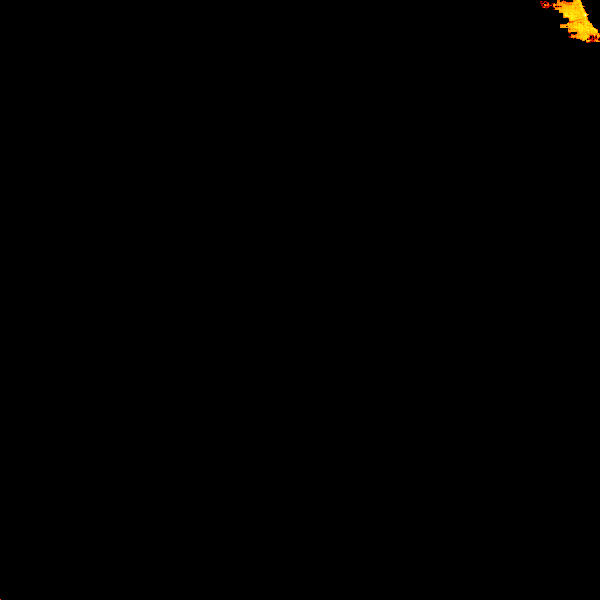

In [114]:
img

The plot indicates, there is a faulty row (or rows) in the database where the coordinates are incorrect. We can easily filter these entries out.

In [115]:
# Delete incorrect entries from crime_data and update the original
# Cutoff latitude was aquired by plotting the data on a temporary
# scatter plot
cutoff_lat = 41.6
crime_data_corr = crime_data[crime_data['Latitude']>cutoff_lat]

In [116]:
# Determine correct scale of figure to create
# a figure with correct proportions
x_max = np.max(crime_data_corr['Longitude'])
x_min = np.min(crime_data_corr['Longitude'])
y_max = np.max(crime_data_corr['Latitude'])
y_min = np.min(crime_data_corr['Latitude'])

x_per_y = (x_max - x_min) / (y_max - y_min)

In [117]:
fs = 5
cvs = ds.Canvas(plot_width=int(fs*200*x_per_y), plot_height=int(fs*200))
agg = cvs.points(crime_data_corr, 'Longitude', 'Latitude')
ds.transfer_functions.Image.border=0
img = tf.set_background(tf.shade(agg, cmap=cm(cc.fire, 0.4), how='log'), 'black')

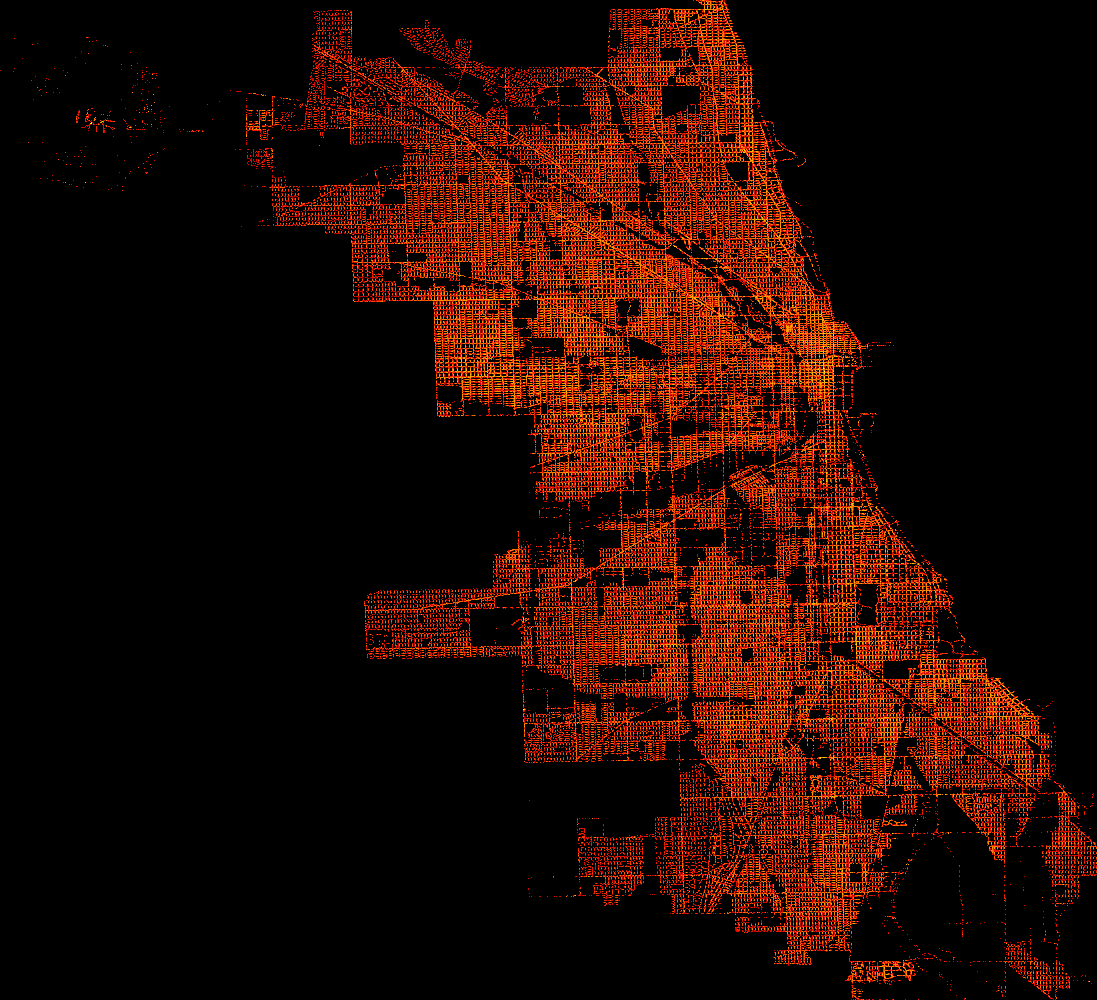

In [118]:
img

## Explore columns

In [119]:
crime_data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [199]:
# Count number of different crime locations
locations_N = crime_data['Location Description'].value_counts()

In [201]:
locations_index = list(locations_N.index)
locations_count = list(locations_N.values)
locations_N_df = pd.DataFrame(data={'Location Description': locations_index, 'Count': locations_count})

In [202]:
locations_N

STREET                   1849252
RESIDENCE                1204590
APARTMENT                 748670
SIDEWALK                  692156
OTHER                     270292
                          ...   
LOADING DOCK                   1
CLEANERS/LAUNDROMAT            1
EXPRESSWAY EMBANKMENT          1
BOAT / WATERCRAFT              1
LIVERY AUTO                    1
Name: Location Description, Length: 212, dtype: int64

In [200]:
# Count number of different crimes
crimes_N = crime_data['Primary Type'].value_counts()

In [194]:
crimes_index = list(crimes_N.index)
crimes_count = list(crimes_N.values)
crimes_N_df = pd.DataFrame(data={'Primary type': crimes_index, 'Count': crimes_count})

In [203]:
crimes_N

THEFT                                1504270
BATTERY                              1300995
CRIMINAL DAMAGE                       808774
NARCOTICS                             730706
ASSAULT                               447112
OTHER OFFENSE                         442109
BURGLARY                              401592
MOTOR VEHICLE THEFT                   327140
DECEPTIVE PRACTICE                    290757
ROBBERY                               267217
CRIMINAL TRESPASS                     202785
WEAPONS VIOLATION                      79580
PROSTITUTION                           69181
PUBLIC PEACE VIOLATION                 49805
OFFENSE INVOLVING CHILDREN             48954
CRIM SEXUAL ASSAULT                    28847
SEX OFFENSE                            27033
INTERFERENCE WITH PUBLIC OFFICER       17180
GAMBLING                               14575
LIQUOR LAW VIOLATION                   14361
ARSON                                  11697
HOMICIDE                               10203
KIDNAPPING

## 1. Bokeh barplot

In [250]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Turbo256 
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

In [318]:
# Gusztustalan spagetti kód
def get_hex_colors(data, cmap=cm.jet):
    
    rgba_colors = [np.array(cmap(i)) for i in np.linspace(0,1,len(data))[::-1]]
    rgb_255_colors = [(c[:3] * 255).astype('int') for c in rgba_colors]
    hex_colors = tuple(['#%02x%02x%02x' % tuple(c) for c in rgb_255_colors])
    
    return hex_colors

In [319]:
hex_colors = get_hex_colors(data=crimes_index, cmap=cm.jet)

In [320]:
output_file("crime_rate.html")

source = ColumnDataSource(data=crimes_N_df)

p = figure(x_range=crimes_index, plot_width=1200, plot_height=800, toolbar_location='right', title='Crime Counts')
p.vbar(x='Primary type', top='Count', width=0.9, source=source,
       line_color='white', fill_color=factor_cmap('Primary type', palette=hex_colors, factors=crimes_index))

p.xaxis.major_label_orientation = 42/180 * np.pi

p.xgrid.grid_line_color = None
#p.legend.label_text_font_size = '6pt'
#p.legend.orientation = 'vertical'
#p.legend.location = (0, -60)

show(p)